In [9]:
import gymnasium
from ray.tune.registry import register_env
from ray.air.integrations.wandb import WandbLoggerCallback, setup_wandb
import ray
# use the mobile-env RLlib wrapper for RLlib
def register(config):
    # importing mobile_env registers the included environments
    import mobile_env
    from mobile_env.wrappers.multi_agent import RLlibMAWrapper

    env = gymnasium.make("mobile-small-ma-v0")
    return RLlibMAWrapper(env)

# register the predefined scenario with RLlib
register_env("mobile-small-ma-v0", register)

In [10]:
ray.__version__

'2.12.0'

In [2]:
import ray


# init ray with available CPUs (and GPUs) and init ray
ray.init(
  num_cpus=6,   # change to your available number of CPUs
  include_dashboard=False,
  ignore_reinit_error=True,
  log_to_driver=False,
)

2024-04-27 20:23:21,811	INFO worker.py:1749 -- Started a local Ray instance.


Python version:,3.9.19
Ray version:,2.12.0


In [15]:
import ray.air
from ray.rllib.algorithms.ppo import PPOConfig

from ray.rllib.policy.policy import PolicySpec
from ray.tune.stopper import MaximumIterationStopper

# Create an RLlib config using multi-agent PPO on mobile-env's small scenario.
config = (
    PPOConfig()
    .environment(env="mobile-small-ma-v0")
    # Here, we configure all agents to share the same policy.
    .multi_agent(
        policies={"shared_policy": PolicySpec()},
        policy_mapping_fn=lambda agent_id, episode, worker, **kwargs: "shared_policy",
    )
    # RLlib needs +1 CPU than configured below (for the driver/traininer?)
    .resources(num_cpus_per_worker=1)
    .rollouts(num_rollout_workers=1)
)

# Create the Trainer/Tuner and define how long to train
tuner = ray.tune.Tuner(
    "PPO",
    run_config=ray.air.RunConfig(
        # Save the training progress and checkpoints locally under the specified subfolder.
        storage_path="/Users/carlosmarinoguera/Documents/class/UT/RL/PROJECT/test",
        # Control training length by setting the number of iterations. 1 iter = 4000 time steps by default.
        stop=MaximumIterationStopper(max_iter=50),
        checkpoint_config=ray.air.CheckpointConfig(checkpoint_at_end=True),
    ),
    param_space=config,
)

# Run training and save the result
result_grid = tuner.fit()

In [1]:
%load_ext tensorboard
%tensorboard --logdir results_rllib//

In [2]:
from ray.rllib.algorithms.algorithm import Algorithm

# load the trained agent from the stored checkpoint
best_result = result_grid.get_best_result(metric="episode_reward_mean", mode="max")
ppo = Algorithm.from_checkpoint(best_result.checkpoint)

NameError: name 'result_grid' is not defined

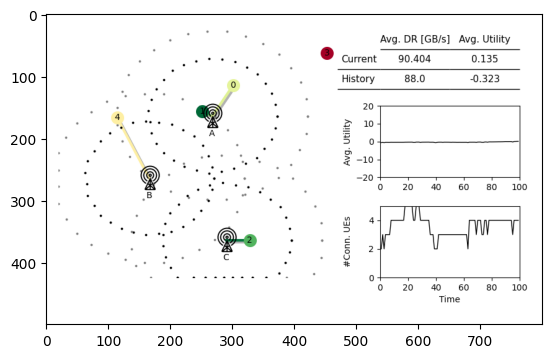

In [14]:
import mobile_env
import matplotlib.pyplot as plt
from IPython import display

# create the env for testing
# pass rgb_array as render mode so the env can be rendered inside the notebook
env = gymnasium.make("mobile-small-ma-v0", render_mode="rgb_array")
obs, info = env.reset()
done = False

# run one episode with the trained model
while not done:
    # gather action from each actor (for each UE)
    action = {}
    for agent_id, agent_obs in obs.items():
        # compute the action for the given agent using the shared policy
        action[agent_id] = ppo.compute_single_action(agent_obs, policy_id="shared_policy")

    # apply actions and perform step on simulation environment
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # render environment as RGB
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)